In [1]:
!pip install emoji

In [2]:
import pandas as pd

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import numpy as np
from math import sqrt

from nltk.util import ngrams
from collections import defaultdict
from collections import  Counter
from wordcloud import WordCloud

import re
import string
import emoji
import gensim # Word Embeddings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout

# Metrics
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, mean_squared_error

# Data Preview


In [3]:
df = pd.read_csv('train.csv')

# Check for null values in the DataFrame
null_counts = df.isnull().sum()

# Print the null value counts
print(null_counts)

print(len(df.index), ' rows of data is clean from Null values')

df.head(3)

text             0
id               0
sentiment        0
annotator        0
annotation_id    0
created_at       0
updated_at       0
lead_time        0
dtype: int64
1009  rows of data is clean from Null values


,text,id,sentiment,annotator,annotation_id,created_at,updated_at,lead_time
0,"Bersatu kita teguh, bercerai kita roboh.",81037,Neutral,27,4231,2022-02-14T15:58:43.745680Z,2022-02-14T15:58:47.080664Z,282799.830
1,semuanya bersatu Bersatu Indonesia Kuat,81001,Neutral,27,4195,2022-02-14T15:56:20.283992Z,2022-02-14T15:56:23.113936Z,282655.843
2,Dulu aku Jenis yang Tak suka sgt tgk mp-mp sho...,80998,Negative,27,4192,2022-02-14T15:55:57.558702Z,2022-02-14T15:56:03.446298Z,282636.179


In [4]:
df

,text,id,sentiment,annotator,annotation_id,created_at,updated_at,lead_time
0,"Bersatu kita teguh, bercerai kita roboh.",81037,Neutral,27,4231,2022-02-14T15:58:43.745680Z,2022-02-14T15:58:47.080664Z,282799.830
1,semuanya bersatu Bersatu Indonesia Kuat,81001,Neutral,27,4195,2022-02-14T15:56:20.283992Z,2022-02-14T15:56:23.113936Z,282655.843
2,Dulu aku Jenis yang Tak suka sgt tgk mp-mp sho...,80998,Negative,27,4192,2022-02-14T15:55:57.558702Z,2022-02-14T15:56:03.446298Z,282636.179
3,Kini360: Pengamal media Kelantan terima dos pe...,80968,Neutral,27,3923,2022-02-12T16:57:58.774007Z,2022-02-12T16:58:04.642062Z,113557.353
4,Kini360: Sabah lanjutkan PKP 3.0 hingga 28 Jun...,80907,Negative,27,3862,2022-02-12T16:53:52.561250Z,2022-02-12T16:53:57.517652Z,113310.237
...,...,...,...,...,...,...,...,...
1004,"Kerajaan kita bukan serba boleh, tapi serba bo...",80189,Negative,27,2178,2022-01-28T04:16:20.626712Z,2022-01-28T04:16:20.626726Z,1.683
1005,Sudah sudah la kak mas woi. Kamu tahu tak semu...,80188,Negative,27,2177,2022-01-28T04:16:18.556006Z,2022-01-28T04:16:18.556020Z,1.015
1006,Nape nak kena tampal gambar Dia pulak...Guna d...,80187,Negative,27,2176,2022-01-28T04:16:17.145907Z,2022-01-28T04:16:17.145921Z,2.036
1007,Bendera putih tu bukannya nak harap bantuan ke...,80186,Negative,27,2175,2022-01-28T04:16:14.729682Z,2022-01-28T04:16:14.729696Z,2.969


# Sentiment Class Distribution

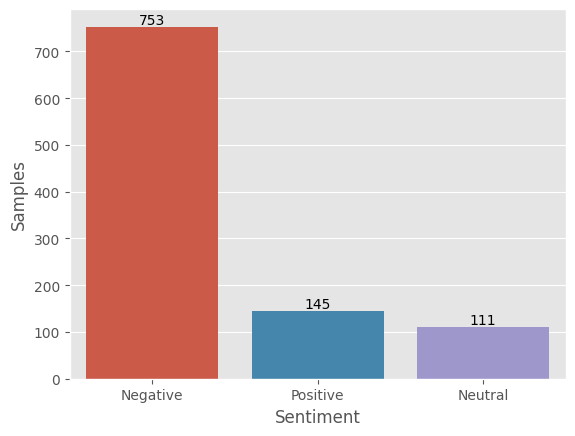

In [5]:
# Count the occurrences of each class
class_counts = df['sentiment'].value_counts()

# Create a bar plot
ax = sns.barplot(x=class_counts.index, y=class_counts)
plt.ylabel('Samples')
plt.xlabel('Sentiment')

# Add count annotations above each bar
for i, count in enumerate(class_counts):
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.show()

Based on this chart, we have an imbalanced dataset. If we train a model on a dataset with more negative than positive labels, the model might learn that predicting "negative" most of the time leads to the correct answer. As a result, when the trained model is used to predict sentiment on new, unseen data, it may be biased towards predicting is as negative, even when that's not true.

To handle data imbalance:
1. Undersampling: Removing some data from the majority class to balance the classes. However, undersampling can lead to loss of information, which may decrease the overall performance.

2. Oversampling: Duplicate examples from the minority class or generate new synthetic examples. A common technique for this is SMOTE. However, oversampling may lead to overfitting as it makes exact copies of existing data.

3. Mix under + over sampling. Undersampling for majority class, oversampling for minority class.

# Resampling

We have a 2nd csv which is a scraped data of malay tweets (the difference is these tweets are random, not specifically political tweets like 1st csv). We will use this data to populate our dataframe so that the data is balanced.

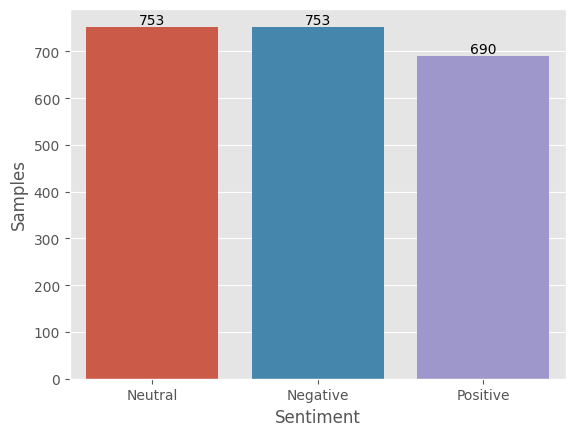

In [6]:
# Load the second dataframe
df2 = pd.read_csv('train2.csv')

# Filter positive and neutral tweets from the second dataframe
positive_tweets = df2[df2['sentiment'] == 'Positive']
neutral_tweets = df2[df2['sentiment'] == 'Neutral']

# Randomly sample 545 positive and 642 neutral tweets from the second df
positive_tweets = positive_tweets.sample(min(len(positive_tweets), 545))
neutral_tweets = neutral_tweets.sample(min(len(neutral_tweets), 642))

# Concatenate the sampled tweets with the initial dataframe
df = pd.concat([df, positive_tweets, neutral_tweets], ignore_index=True)

# Count the occurrences of each class
class_counts = df['sentiment'].value_counts()

# Create a bar plot
ax = sns.barplot(x=class_counts.index, y=class_counts)
plt.ylabel('Samples')
plt.xlabel('Sentiment')

# Add count annotations above each bar
for i, count in enumerate(class_counts):
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.show()

# Exploratory Data Analysis

## Number of characters in tweets

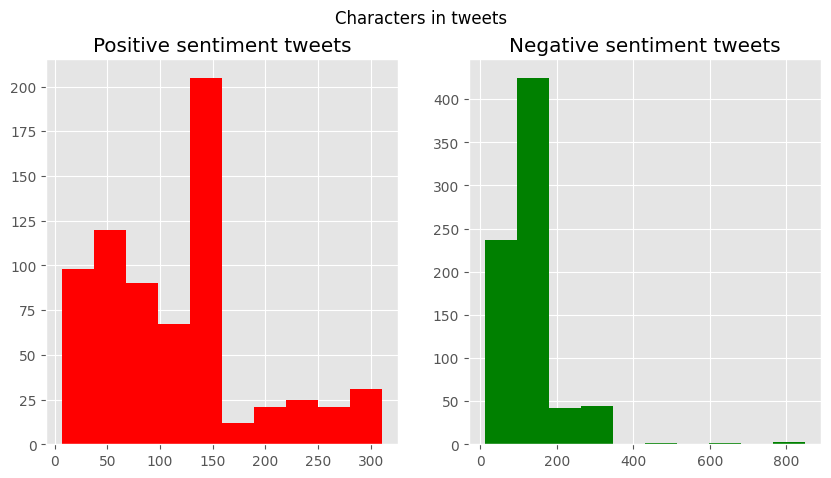

In [7]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Filter tweets with sentiment value 1 (positive) and calculate the length of text
tweet_len_pos = df[df['sentiment'] == 'Positive']['text'].str.len()
ax1.hist(tweet_len_pos, color='red')
ax1.set_title('Positive sentiment tweets')

# Filter tweets with sentiment value 0 (negative) and calculate the length of text
tweet_len_neg = df[df['sentiment'] == 'Negative']['text'].str.len()
ax2.hist(tweet_len_neg, color='green')
ax2.set_title('Negative sentiment tweets')

# Set overall title
fig.suptitle('Characters in tweets')

# Display the plot
plt.show()

## Number of words in tweets

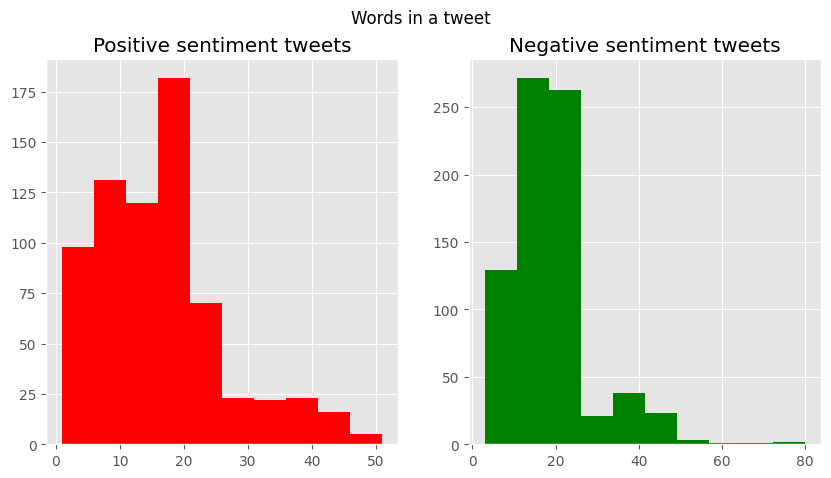

In [8]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Filter tweets with sentiment 'positive' and calculate the number of words in text
tweet_len_pos = df[df['sentiment'] == 'Positive']['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len_pos, color='red')
ax1.set_title('Positive sentiment tweets')

# Filter tweets with sentiment 'negative' and calculate the number of words in text
tweet_len_neg = df[df['sentiment'] == 'Negative']['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len_neg, color='green')
ax2.set_title('Negative sentiment tweets')

# Set overall title
fig.suptitle('Words in a tweet')

# Display the plot
plt.show()

## Average word length in a tweet

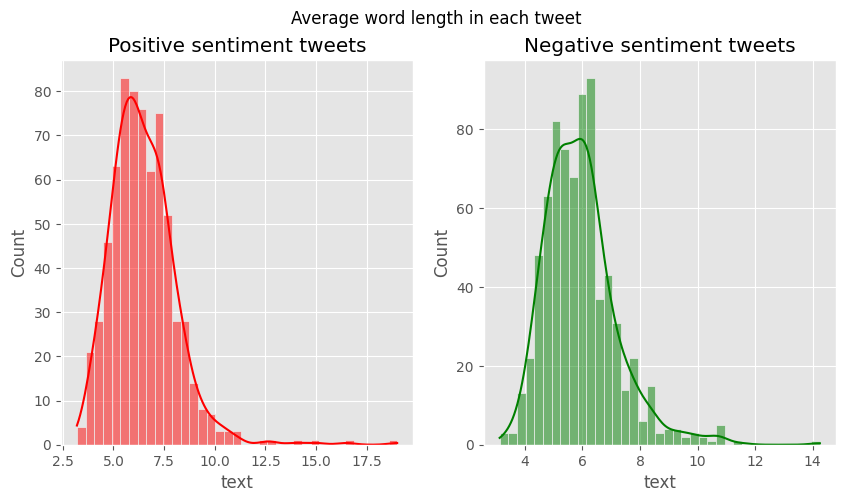

In [9]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Filter tweets with sentiment 'positive' and calculate the average word length
word_pos = df[df['sentiment'] == 'Positive']['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word_pos.map(lambda x: np.mean(x)), ax=ax1, color='red', kde=True)
ax1.set_title('Positive sentiment tweets')

# Filter tweets with sentiment 'negative' and calculate the average word length
word_neg = df[df['sentiment'] == 'Negative']['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word_neg.map(lambda x: np.mean(x)), ax=ax2, color='green', kde=True)
ax2.set_title('Negative sentiment tweets')

# Set overall title
fig.suptitle('Average word length in each tweet')

# Display the plot
plt.show()

# Word Cloud in all tweets

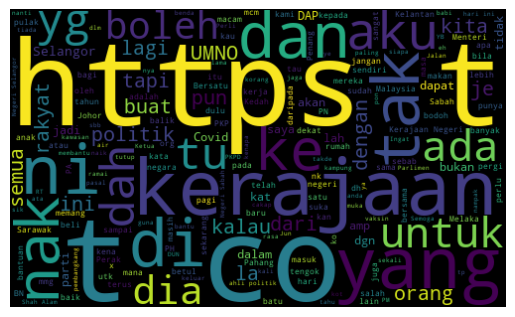

In [10]:
# Plot the Word Cloud
allwords= ''.join( [twts for twts in df["text"]])
wordCloud = WordCloud (width=500, height=300, random_state=21, max_font_size=119).generate(allwords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')

plt.show()

# N-gram analysis

A technique used in NLP to analyze the sequential patterns of words in a text. An n-gram can be thought of as a sliding window of n words that moves across the text, extracting each group of words it encounters. For example, let's consider the sentence: "I love to code."

A 1-gram (unigram) analysis would involve looking at each individual word separately: "I", "love", "to", "code".
A 2-gram (bigram) analysis would involve examining pairs of words: "I love", "love to", "to code".
A 3-gram (trigram) analysis would involve considering groups of three consecutive words: "I love to", "love to code".

By analyzing these n-grams, we can gain insights into the frequency and patterns of word combinations within a text. For example, in the bigram "tak puas," the word "tak" changes the sentiment of "puas" to negative.

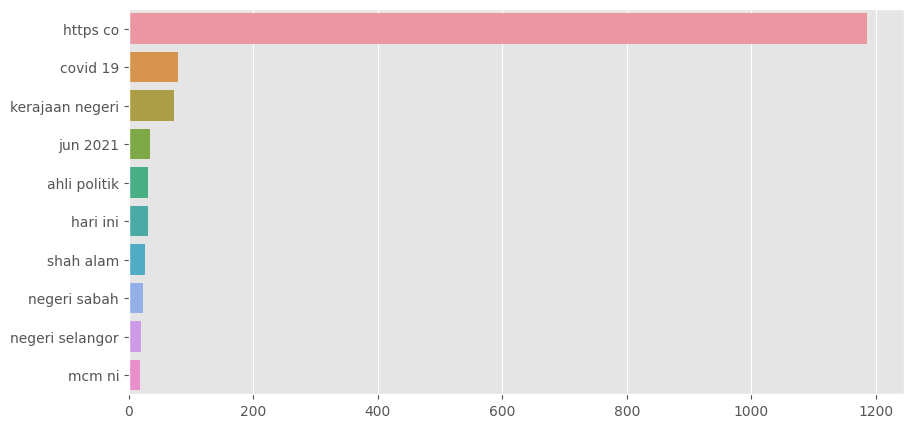

In [11]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10, 5))
top_tweet_bigrams = get_top_tweet_bigrams(df['text'])[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)
plt.show()

In [12]:
# List of malay stop words
STOP_WORDS = set("""
ada adalah adanya adapun agak agaknya agar akan akankah akhir akhiri akhirnya
aku akulah amat amatlah anda andalah antar antara antaranya apa apaan apabila
apakah apalagi apatah artinya asal asalkan atas atau ataukah ataupun awal
awalnya
bagai bagaikan bagaimana bagaimanakah bagaimanapun bagi bagian bahkan bahwa
bahwasanya baik bakal bakalan balik banyak byk bapak baru bawah beberapa begini
beginian beginikah beginilah begitu begitukah begitulah begitupun bekerja
belakang belakangan belum belumlah benar benarkah benarlah berada berakhir
berakhirlah berakhirnya berapa berapakah berapalah berapapun berarti berawal
berbagai berdatangan beri berikan berikut berikutnya berjumlah berkali-kali
berkata berkehendak berkeinginan berkenaan berlainan berlalu berlangsung
berlebihan bermacam bermacam-macam bermaksud bermula bersama bersama-sama
bersiap bersiap-siap bertanya bertanya-tanya berturut berturut-turut bertutur
berujar berupa besar betul betulkah biasa biasanya bila bilakah bisa bisakah
boleh bolehkah bolehlah buat bukan bukankah bukanlah bukannya bulan bung
cara caranya cukup cukupkah cukuplah cuma
dahulu dalam dan dapat dari daripada datang dekat demi demikian demikianlah
dengan dgn depan di dia diakhiri diakhirinya dialah diantara diantaranya diberi
diberikan diberikannya dibuat dibuatnya didapat didatangkan digunakan
diibaratkan diibaratkannya diingat diingatkan diinginkan dijawab dijelaskan
dijelaskannya dikarenakan dikatakan dikatakannya dikerjakan diketahui
diketahuinya dikira dilakukan dilalui dilihat dimaksud dimaksudkan
dimaksudkannya dimaksudnya diminta dimintai dimisalkan dimulai dimulailah
dimulainya dimungkinkan dini dipastikan diperbuat diperbuatnya dipergunakan
diperkirakan diperlihatkan diperlukan diperlukannya dipersoalkan dipertanyakan
dipunyai diri dirinya disampaikan disebut disebutkan disebutkannya disini
disinilah ditambahkan ditandaskan ditanya ditanyai ditanyakan ditegaskan
ditujukan ditunjuk ditunjuki ditunjukkan ditunjukkannya ditunjuknya dituturkan
dituturkannya diucapkan diucapkannya diungkapkan dong dua dulu
empat enggak enggaknya entah entahlah
guna gunakan
hal hampir hanya hanyalah hari harus haruslah harusnya hendak hendaklah
hendaknya hingga
ia ialah ibarat ibaratkan ibaratnya ibu ikut ingat ingat-ingat ingin inginkah
inginkan ini inikah inilah itu itukah itulah
jadi jadilah jadinya jangan jangankan janganlah jauh jawab jawaban jawabnya
jelas jelaskan jelaslah jelasnya jika jikalau juga jumlah jumlahnya justru
kala kalau kalaulah kalaupun kalian kami kamilah kamu kamulah kan kapan
kapankah kapanpun karena karenanya kasus kata katakan katakanlah katanya ke
keadaan kebetulan kecil kedua keduanya keinginan kelamaan kelihatan
kelihatannya kelima keluar kembali kemudian kemungkinan kemungkinannya kenapa
kepada kepadanya kesampaian keseluruhan keseluruhannya keterlaluan ketika
khususnya kini kinilah kira kira-kira kiranya kita kitalah kok kurang
lagi lagian lah lain lainnya lalu lama lamanya lanjut lanjutnya lebih lewat
lima luar
macam maka makanya makin malah malahan mampu mampukah mana manakala manalagi
masa masalah masalahnya masih masihkah masing masing-masing mau maupun
melainkan melakukan melalui melihat melihatnya memang memastikan memberi
memberikan membuat memerlukan memihak meminta memintakan memisalkan memperbuat
mempergunakan memperkirakan memperlihatkan mempersiapkan mempersoalkan
mempertanyakan mempunyai memulai memungkinkan menaiki menambahkan menandaskan
menanti menanti-nanti menantikan menanya menanyai menanyakan mendapat
mendapatkan mendatang mendatangi mendatangkan menegaskan mengakhiri mengapa
mengatakan mengatakannya mengenai mengerjakan mengetahui menggunakan
menghendaki mengibaratkan mengibaratkannya mengingat mengingatkan menginginkan
mengira mengucapkan mengucapkannya mengungkapkan menjadi menjawab menjelaskan
menuju menunjuk menunjuki menunjukkan menunjuknya menurut menuturkan
menyampaikan menyangkut menyatakan menyebutkan menyeluruh menyiapkan merasa
mereka merekalah merupakan meski meskipun meyakini meyakinkan minta mirip
misal misalkan misalnya mula mulai mulailah mulanya mungkin mungkinkah
nah naik namun nanti nantinya nyaris nyatanya
oleh olehnya
pada padahal padanya pak paling panjang pantas para pasti pastilah penting
pentingnya per percuma perlu perlukah perlunya pernah persoalan pertama
pertama-tama pertanyaan pertanyakan pihak pihaknya pukul pula pun punya
rasa rasanya rata rupanya
saat saatnya saja sajalah saling sama sama-sama sambil sampai sampai-sampai
sampaikan sana sangat sangatlah satu saya sayalah se sebab sebabnya sebagai
sebagaimana sebagainya sebagian sebaik sebaik-baiknya sebaiknya sebaliknya
sebanyak sebegini sebegitu sebelum sebelumnya sebenarnya seberapa sebesar
sebetulnya sebisanya sebuah sebut sebutlah sebutnya secara secukupnya sedang
sedangkan sedemikian sedikit sedikitnya seenaknya segala segalanya segera
seharusnya sehingga seingat sejak sejauh sejenak sejumlah sekadar sekadarnya
sekali sekali-kali sekalian sekaligus sekalipun sekarang sekarang sekecil
seketika sekiranya sekitar sekitarnya sekurang-kurangnya sekurangnya sela
selain selaku selalu selama selama-lamanya selamanya selanjutnya seluruh
seluruhnya semacam semakin semampu semampunya semasa semasih semata semata-mata
semaunya sementara semisal semisalnya sempat semua semuanya semula sendiri
sendirian sendirinya seolah seolah-olah seorang sepanjang sepantasnya
sepantasnyalah seperlunya seperti sepertinya sepihak sering seringnya serta
serupa sesaat sesama sesampai sesegera sesekali seseorang sesuatu sesuatunya
sesudah sesudahnya setelah setempat setengah seterusnya setiap setiba setibanya
setidak-tidaknya setidaknya setinggi seusai sewaktu siap siapa siapakah
siapapun sini sinilah soal soalnya suatu sudah sudahkah sudahlah supaya
tadi tadinya tahu tahun tambah tambahnya tampak tampaknya tandas tandasnya
tanpa tanya tanyakan tanyanya tapi tegas tegasnya telah tempat tengah tentang
tentu tentulah tentunya tepat terakhir terasa terbanyak terdahulu terdapat
terdiri terhadap terhadapnya teringat teringat-ingat terjadi terjadilah
terjadinya terkira terlalu terlebih terlihat termasuk ternyata tersampaikan
tersebut tersebutlah tertentu tertuju terus terutama tetap tetapi tiap tiba
tiba-tiba tidakkah tidaklah tiga tinggi toh tunjuk turut tutur tuturnya
ucap ucapnya ujar ujarnya umum umumnya ungkap ungkapnya untuk usah usai
waduh wah wahai waktu waktunya walau walaupun wong
yaitu yakin yakni yang yg
""".split()
)
# Credit to a malay contributor to the spaCy library: https://github.com/explosion/spaCy/pull/12602/files

# Although, 'tidak','tak', 'takde', 'takda', 'tk', 'x', are stopwords,
# we don't remove them from the training data because it has important meaning as it can flip the sentiment.

# For eg, 'not good' is a negative sentiment, but if we remove 'not' as it's technically a stopword,
# we will get 'good' which is a positive sentiment.

In [13]:
# Create corpus list for all words in the text

def create_corpus(sentiment):
    corpus=[]

    for x in df[df['sentiment']==sentiment]['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Analyze the most common stopwords in Negative tweets.


<BarContainer object of 10 artists>

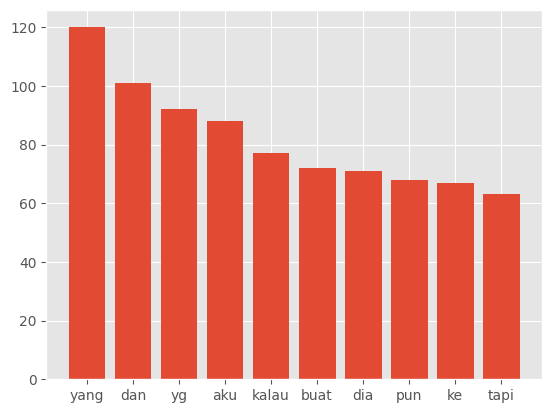

In [14]:
negative_corpus=create_corpus('Negative')

dic=defaultdict(int)
for word in negative_corpus:
    if word in STOP_WORDS:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

x,y=zip(*top)
plt.bar(x,y)

# Analyze the most common stopwords in Positive tweets.

<BarContainer object of 10 artists>

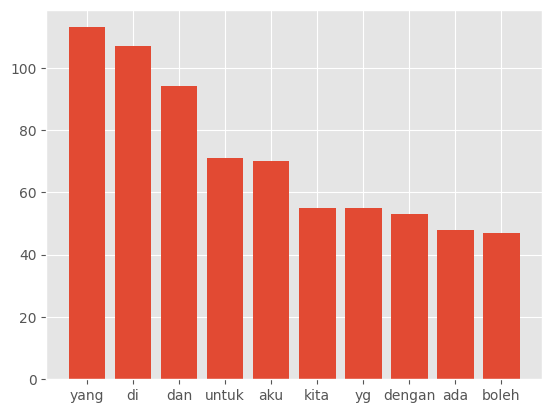

In [15]:
positive_corpus=create_corpus("Positive")

dic=defaultdict(int)
for word in positive_corpus:
    if word in STOP_WORDS:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

x,y=zip(*top)
plt.bar(x,y)

# Analyze the most common words (excl stopwords) in Negative tweets.

<AxesSubplot:>

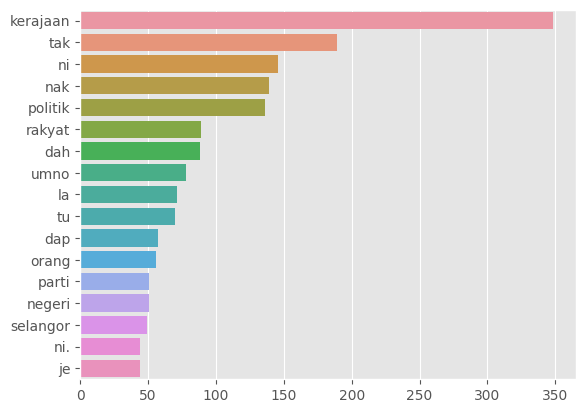

In [16]:
counter = Counter(negative_corpus)
most = counter.most_common()
x = []
y = []
for word, count in most[:40]:
    if word not in STOP_WORDS:
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

# Analyze the most common words (excl stopwords) in Positive tweets.

<AxesSubplot:>

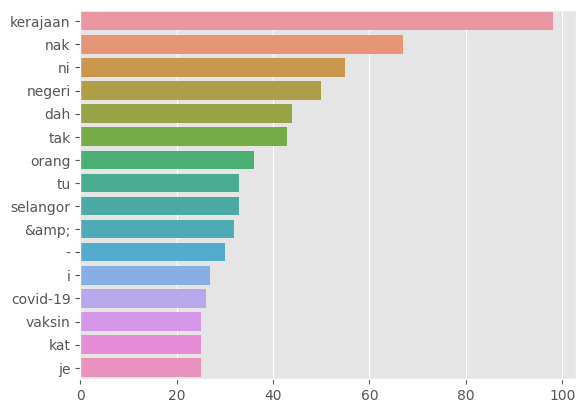

In [17]:
counter = Counter(positive_corpus)
most = counter.most_common()
x = []
y = []
for word, count in most[:40]:
    if word not in STOP_WORDS:
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

# Data Cleaning

In [18]:
df_dirty = df.copy() # save a copy of df before cleaning

## Remove stopwords

In [19]:
print('Before: ', df.iloc[11]['text'])

def removeStopWords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in STOP_WORDS]
    return ' '.join(filtered_words)

df['text'] = df['text'].apply(removeStopWords)
print('After: ', df.iloc[11]['text'])

Before:  Bekas MB Perak, Datuk Seri Zambry Abdul Kadir dilantik Setiausaha Agung BN yang baru. #GetaranMY | #TERKINI
After:  Bekas MB Perak, Datuk Seri Zambry Abdul Kadir dilantik Setiausaha Agung BN baru. #GetaranMY | #TERKINI


## Remove URL

In [20]:
print('Before:', df.iloc[5]['text'])

def cleanLink(text):
    text = re.sub(r'https?:\/\/\S+', '', text)  # remove any type of link
    return text

df['text'] = df['text'].apply(cleanLink)
print('After:', df.iloc[5]['text'])

Before: Lastly, pi jumpa doktor kerajaan, ckp doktor kau tak nak ubat. Tolong jgn buang duit negara bayar subsidi https://t.co/2jIzHiXXSA
After: Lastly, pi jumpa doktor kerajaan, ckp doktor kau tak nak ubat. Tolong jgn buang duit negara bayar subsidi 


## Remove hashtag symbol

In [21]:
print('Before:', df.iloc[11]['text'])

def cleanHashtag(text):
  text = re.sub(r'#', '', text) # remove any #hashtag
  return text

# After clean hashtag
df['text'] = df['text'].apply(cleanHashtag)
print('After:', df.iloc[11]['text'])

Before: Bekas MB Perak, Datuk Seri Zambry Abdul Kadir dilantik Setiausaha Agung BN baru. #GetaranMY | #TERKINI
After: Bekas MB Perak, Datuk Seri Zambry Abdul Kadir dilantik Setiausaha Agung BN baru. GetaranMY | TERKINI


## Remove user @mention

In [22]:
print('Before:', df.iloc[20]['text'])

def cleanMention(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # remove any @mention
    return text

# After clean @ mention
df['text'] = df['text'].apply(cleanMention)
print('After:', df.iloc[20]['text'])

Before: @limlipeng durian Raub pengundi, sokong DAP. Ahaks lkshinaislam durianraub 
After:  durian Raub pengundi, sokong DAP. Ahaks lkshinaislam durianraub 


## Remove punctuations

In [23]:
print('Before:', df.iloc[11]['text'])

def cleanPunctuations(text):
    text = re.sub('[' + string.punctuation + ']', '', text)  # Remove punctuations
    return text

# After clean punctuation
df['text'] = df['text'].apply(cleanPunctuations)
print('After:', df.iloc[11]['text'])

Before: Bekas MB Perak, Datuk Seri Zambry Abdul Kadir dilantik Setiausaha Agung BN baru. GetaranMY | TERKINI
After: Bekas MB Perak Datuk Seri Zambry Abdul Kadir dilantik Setiausaha Agung BN baru GetaranMY  TERKINI


## Remove 'RT' (Retweet) word as it's meaningless

In [24]:
print('Before:', df.iloc[14]['text'])

def cleanRT(text):
    text = re.sub(r'RT[\s]+', '', text) # remove any 'RT' word (stands for Retweet)
    return text

df['text'] = df['text'].apply(cleanRT)
print('After:',df.iloc[14]['text'])

Before: RT   Tumpang promote Hi korang jom support bisnes partner i If korang ph 
After: Tumpang promote Hi korang jom support bisnes partner i If korang ph 


## Remove emoji

In [25]:
# Before clean emoji
emoji_text = 'Hello! 🌈 😊😊😊 ❌🔧'
print('Before:', emoji_text)

def cleanEmoji(text):
  # emoticons (facial expression like smiley) are not removed since we will replace it with text representation, only other noisy emojis are removed
  emoji_pattern = re.compile("["
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs i.e. 🌟 ⚡️ 🌈 💡 🔧
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # additional symbols and shapes i.e. ✂️ ❌ ✔️
                           u"\U000024C2-\U0001F251"  # miscellaneous symbols i.e. Ⓜ️ 🔀 🔁
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)

  # Preserves the sentiment conveyed by the emoticons by converting them into textual format like :grinning_face:
  text = emoji.demojize(text)

  # Remove colons(:) in :grinning_face: but do not remove the underscore so that vectorization will consider them as 1 word
  # Add a space around each colon to separate consecutive textual emojis 😊😊😊 and then remove extra spaces
  text = re.sub(r'(:\w+:| +)', lambda match: ' ' if match.group(0).isspace() else f' {match.group(0)} ', text.strip())

  return text

# Example after clean emoji
print('After:', cleanEmoji(emoji_text))

df['text'] = df['text'].apply(cleanEmoji)

Before: Hello! 🌈 😊😊😊 ❌🔧
After: Hello!  :smiling_face_with_smiling_eyes:  :smiling_face_with_smiling_eyes:  :smiling_face_with_smiling_eyes: 


# Remove specific words
These words occur frequently across different sentiment classes and do not provide discriminative information.

In [26]:
print('Before:', df.iloc[11]['text'])

def removeSpecificWords(text):
    num_words = [
        "satu", "dua", "tiga", "empat", "lima", "enam", "tujuh", "lapan", "sembilan",
        "sepuluh", "sebelas", "belas", "puluh", "ratus", "ribu", "juta", "million", "billion",
        "trillion", "kuadrilion", "kuintilion", "sekstilion", "septilion", "oktilion", "nonilion",
        "desilion"
    ]

    currencies = ["usd", "rm", "myr", "rp", "idr", "rmb", "sgd"]

    months = [
        "januari", "februari", "mac", "april", "mei", "jun", "julai", "ogos", "september",
        "oktober", "november", "disember", "january", "february", "march", "may", "june",
        "july", "august", "october", "december", "jan", "feb", "mac", "jun", "sept", "okt", "nov", "dis"
    ]

    entities = [
    "kerajaan", "parti", "umno", "bn", "ph", "pkr", "pas", "pn", "dap", "malaysia", "negara", "persekutuan",
    "wilayah", "daerah", "dun", "parlimen", "negeri", "selangor", "pahang", "perak",
    "terengganu", "perlis", "johor", "kelantan", "kedah", "pulau", "penang", "melaka", "sabah", "sarawak"
    ]


    # Split the text into individual words
    words = text.lower().split()

    # Remove the specific words
    cleaned_words = [word for word in words if word not in num_words
                     and word not in currencies
                     and word not in months
                     and word not in entities]

    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text

# Apply the function to the 'text' column
df['text'] = df['text'].apply(removeSpecificWords)
print('After:', df.iloc[11]['text'])

Before: Bekas MB Perak Datuk Seri Zambry Abdul Kadir dilantik Setiausaha Agung BN baru GetaranMY TERKINI
After: bekas mb datuk seri zambry abdul kadir dilantik setiausaha agung baru getaranmy terkini


In [27]:
def preprocessing(text):
  text = removeStopWords(text)
  text = cleanLink(text)
  text = cleanHashtag(text)
  text = cleanPunctuations(text)
  text = cleanRT(text)
  text = cleanEmoji(text)
  text = removeSpecificWords(text)
  return text

# Word Cloud: Before vs After data cleaning


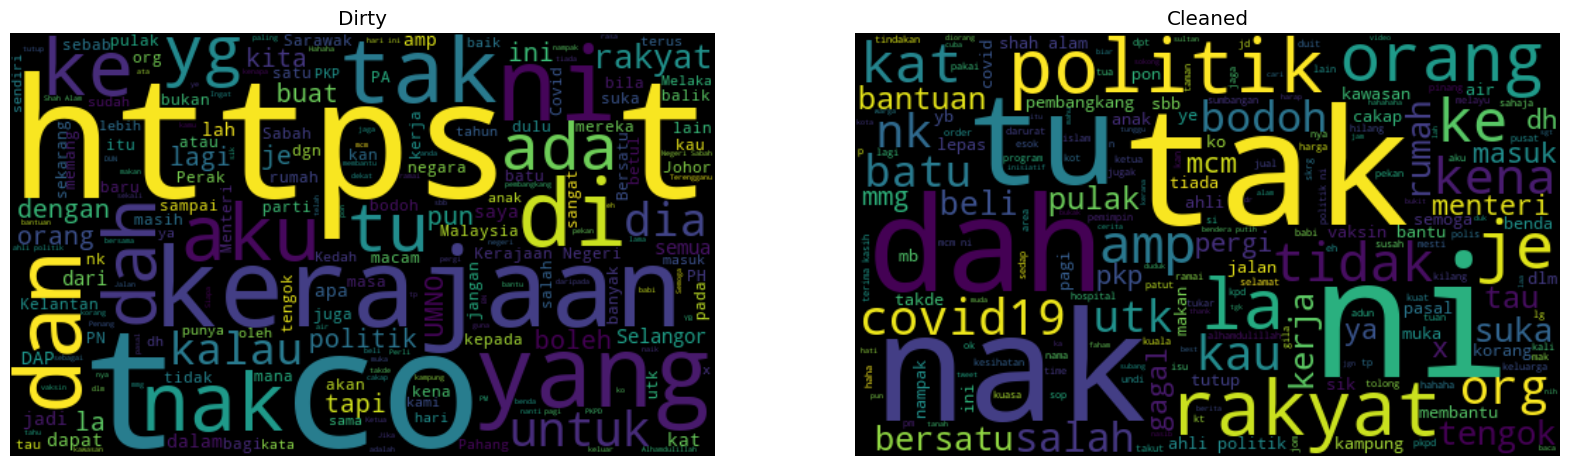

In [28]:
allwords_dirty = ' '.join([twts for twts in df_dirty["text"]])
allwords_cleaned = ' '.join([twts for twts in df["text"]])

wordCloud_dirty = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allwords_dirty)
wordCloud_cleaned = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(allwords_cleaned)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Display the word cloud of pre-cleaned tweets:
ax[0].imshow(wordCloud_dirty, interpolation='bilinear')
ax[0].set_title('Dirty')
ax[0].axis('off')

# Display the word cloud of cleaned tweets:
ax[1].imshow(wordCloud_cleaned, interpolation='bilinear')
ax[1].set_title('Cleaned')
ax[1].axis('off')

plt.show()

# Calculate the number of unique words

In [29]:
unique_words = set(" ".join(df['text']).split())
num_unique_words = len(unique_words)
print("Number of unique words:", num_unique_words)

Number of unique words: 8270


## Delete column text with empty string ' ' after we've removed various words in data cleaning

In [30]:
# Find indices of empty string rows
empty_string_indices = df[df['text'].str.strip().eq('')].index
print('Before:',len(empty_string_indices))

# Delete rows with empty strings
df = df.drop(empty_string_indices)

# Verify that empty string rows are removed
empty_strings = df['text'].str.strip().eq('').sum()
print('After:',empty_strings)

Before: 10
After: 0


# Check sentiment class distribution after rows deleted

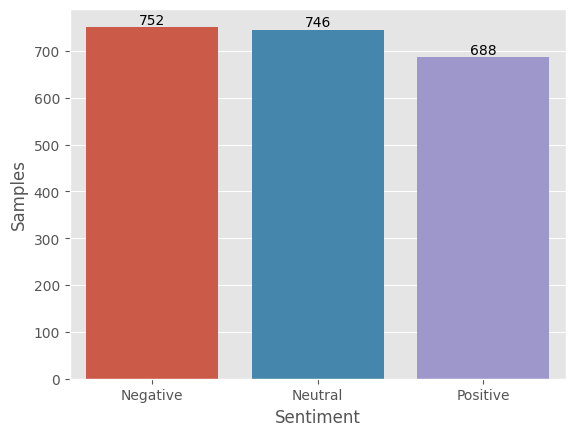

In [31]:
# Count the occurrences of each class
class_counts = df['sentiment'].value_counts()

# Create a bar plot
ax = sns.barplot(x=class_counts.index, y=class_counts)
plt.ylabel('Samples')
plt.xlabel('Sentiment')

# Add count annotations above each bar
for i, count in enumerate(class_counts):
    ax.annotate(str(count), xy=(i, count), ha='center', va='bottom')

plt.show()

In [32]:
# Convert sentiment values (Negative, Positive, Neutral) string into integer (0,1,2) for faster processing
unique_sentiments = df['sentiment'].unique()
print(unique_sentiments)

sentiment_mapping = {'Negative': 0, 'Positive': 1, 'Neutral': 2, 'negative': 0, 'positive': 1, 'neutral': 2}

# Replace the values in the 'sentiment' column using the mapping
df['sentiment'] = df['sentiment'].map(sentiment_mapping)
print(df['sentiment'].dtype)
df.head(3)

['Neutral' 'Negative' 'Positive']
int64


,text,id,sentiment,annotator,annotation_id,created_at,updated_at,lead_time
0,bersatu teguh bercerai roboh,81037,2,27,4231,2022-02-14T15:58:43.745680Z,2022-02-14T15:58:47.080664Z,282799.830
1,bersatu bersatu indonesia kuat,81001,2,27,4195,2022-02-14T15:56:20.283992Z,2022-02-14T15:56:23.113936Z,282655.843
2,jenis tak suka sgt tgk mpmp showoff diorang ke...,80998,0,27,4192,2022-02-14T15:55:57.558702Z,2022-02-14T15:56:03.446298Z,282636.179


# Drop neutral sentiment
The goal is to only differentiate positive and negative tweets, which simplifies the machine learning process. Moreover, in politics and product reviews, neutral opinions are not significant for analysis.

In [33]:
# Remove neutral sentiment since this is not relevant to our machine learning use case
df = df[df['sentiment'] != 2]

# Machine Learning

In [34]:
# Create a positive & negative corpus of unique words so we can analyze the most common words in them for feature engineering
def create_corpus(df, sentiment):
    corpus = []

    for x in df[df['sentiment'] == sentiment]['text'].str.split():
        for i in x:
            corpus.append(i.lower())

    word_freq = Counter(corpus)
    most_common_words = word_freq.most_common()  # This will return a list of tuples, where each tuple is a word and its frequency, sorted by frequency

    return most_common_words  # Returning the sorted list of tuples

# Just to run and check it once. We will hide the printed unique words since the output is too long

# sorted_negative_corpus = create_corpus(df, 0)
# print(sorted_negative_corpus)

# sorted_positive_corpus = create_corpus(df, 1)
# print(sorted_positive_corpus)

In [35]:
BAD_WORDS = ['babi', 'bodoh', 'bodoe', 'anjay', 'anjir', 'njir', 'tenok', 'cipan', 'belen', 'murahan', 'seranah', 'ludah', 'tercyduk', 'sibuk', 'umngok', 'dapig', 'santau', 'mabok', 'sawan', 'butoh', 'anak haram', 'duit haram', 'haram jadah', 'celaka', 'dijarah', 'merempat', 'anasir', 'penjajah', 'bangang', 'bengong', 'babun', 'bongok', 'gila', 'kejam', 'zalim', 'jahat', 'taik', 'tahi', 'sia-sia', 'pukimak', 'puki', 'sial', 'anjing', 'konek', 'burit', 'pantat', 'setan', 'syaitan', 'iblis', 'laknat', 'lancau', 'nate', 'berok', 'natang', 'betina', 'pelacur', 'miang', 'gelenyar', 'gedik', 'jantan', 'padah', 'biawak', 'lintah', 'buaya', 'parasit', 'palat', 'penunggang', 'gatal', 'lucah', 'duitan', 'kaki', 'kikis', 'spin', 'penjilat', 'bodek', 'pengampu', 'ampu', 'penampaq', 'sekeh' 'lan jio', 'lanjio', 'cibai', 'shibal', 'sohai', 'keling', 'keparat', 'mak ko ijau', 'mak ko hijau', 'mak kau hijau', 'bangsat', 'sakit', 'punca', 'hodoh', 'busuk', 'kroni', 'buncit', 'gemuk', 'gemok', 'bengkok', 'boros', 'bazir', 'lambat', 'pahit', 'masin', 'masam', 'kelat', 'hamis', 'hapak', 'hanyir', 'tengik', 'pedih', 'sedih', 'nangis', 'teriak', 'jerit', 'meraung', 'memekak', 'melalak', 'kecewa', 'gopoh', 'curiga', 'ragu', 'gelabah', 'kelat', 'ketat', 'sendat', 'penakut', 'terabur', 'bersepah', 'kasar', 'lemah', 'lembik', 'lepu', 'lesu', 'lalai', 'layu', 'peliwat', 'semburit', 'kunyit', 'aneh', 'pelik', 'basi', 'kotor', 'bosan', 'hambar', 'serabut', 'kabut', 'gawat', 'hancur', 'musnah', 'patah', 'putus', 'pecah', 'berderai', 'cerai', 'bilau', 'sakai', 'sepi', 'sengsara', 'muram', 'carut', 'tenyeh', 'tumbuk', 'sepak', 'tampar', 'lempang', 'baling', 'humban', 'buang', 'campak', 'pondan', 'bapok', 'buas', 'seram', 'ngeri', 'seriau', 'ngilu', 'pilu', 'pelir', 'diselar', 'lepas tangan', 'binasa', 'hentam', 'bidas', 'rampas', 'rosak', 'kusut', 'sondol', 'langgar', 'menyampuk', 'amuk', 'serang', 'gaduh', 'terjah', 'gocoh', 'lawan', 'bertarung', 'perang', 'perampas', 'bertengkar', 'bebel', 'mulut murai', 'panjang tangan', 'rembat', 'tiru', 'plagiat', 'hantu', 'kontol', 'kolot', 'lapuk', 'mundur', 'terkebelakang', 'ketinggalan', 'barai', 'mentekedarah', 'gila gamor', 'menyampah', 'meluat', 'menyusahkan', 'jijik', 'loya', 'ganggu', 'kacau', 'kote', 'najis', 'latah', 'sampah', 'sarap', 'buangan', 'hampas', 'sisa', 'reja', 'semak', 'keji', 'senonoh', 'cabul', 'nanang', 'durjana', 'derhaka', 'pantang', 'kepala', 'otak', 'hotak', 'bapak', 'bana', 'timun', 'jimbit', 'hanat', 'waknat', 'cam cb', 'telo', 'kecut', 'kepam', 'puting', 'hitam', 'kurap', 'berkerak', 'bambu', 'sekolahkan', 'kena bahan', 'bau tengik', 'anti', 'antivaksin', 'bahlol', 'bahalol', 'bahlul', 'bebal', 'bebai', 'banggang', 'toksik', 'toksin', 'hasut', 'caci', 'maki', 'cerca', 'reka cerita', 'slow', 'lembap', 'marah', 'garang', 'sombong', 'poyo', 'berlagak', 'acah', 'mencapap', 'mencapub', 'menunjuk', 'takbur', 'ujub', 'musuh', 'bersekongkol', 'riak', 'picisan', 'publisiti', 'risau', 'bimbang', 'cemas', 'bising', 'tengking', 'tipu', 'curi', 'malas', 'cuai', 'leka', 'jahat', 'zalim', 'kebudakan', 'kedekut', 'bakhil', 'berkira', 'dendam', 'benci', 'tak kuasa', 'jahanam', 'bontot', 'iri', 'khianat', 'umpat', 'mengata', 'kutuk', 'hina', 'sembap', 'degil', 'perlekeh', 'racun', 'barah', 'panas', 'egois', 'tak bertanggungjawab', 'tak percaya', 'lesap', 'mengaburi', 'dalang', 'penjenayah', 'helah', 'daya', 'perasan', 'hidung tinggi', 'padan muka', 'teghajang', 'siku', 'jentik', 'terajang', 'angkuh', 'dusta', 'tarah', 'pelaq', 'tindakan', 'hilang', 'ceroboh', 'bongkak', 'eksploitasi', 'mengabaikan', 'hukuman', 'tindas', 'penindasan', 'ditindas', 'manipulatif', 'manipulasi', 'sekodeng', 'kurang kasih sayang', 'tamak', 'munafik', 'munafiq', 'penting diri', 'psiko', 'empati', 'bohong', 'menyesal', 'kesal', 'sesal', 'samun', 'ragut', 'rogol', 'terpalit', 'cemar', 'panik', 'bodo', 'terpesong', 'termakan', 'umpan', 'pancing', 'kantoi', 'curang', 'dera', 'selingkuh', 'nepotisma', 'kronisma', 'nepotisme', 'kronisme', 'terjerumus', 'terjebak', 'terperangkap', 'permainan', 'fitnah', 'seks', 'seksa', 'lingkup', 'israel', 'dajal', 'dajjal', 'perangai', 'sebok', 'kritik', 'bangkang', 'tolak', 'rusuh', 'sekat', 'penzina', 'menyalahgunakan', 'baran', 'songlap', 'sakau', 'rompak', 'mok', 'bapak ayam', 'boring', 'penat', 'letih', 'haprak', 'harapkan pagar', 'harapkan pegar', 'haruan makan anak', 'spender', 'seluar dalam', 'hingusan', 'gagal', 'huru-hara', 'biadap', 'lancap', 'romen', 'hampeh', 'kafir', 'selek', 'pengkid', 'lampi', 'kepoh', 'kiamsiap', 'pailang', 'gangster', 'samseng', 'bantai', 'kecam', 'ejek', 'boo', 'pantek', 'cipap', 'punggung', 'londeh', 'layut', 'jamban', 'tetek', 'kopek', 'pepek', 'cilakak', 'cilaker', 'cilake', 'jilake', 'jilaker', 'pelempang', 'jalang', 'botak', 'lutut', 'palatao', 'ikut kepala', 'jenuh', 'pisau cukur', 'parang', 'pancung', 'rejam', 'tembak', 'sula', 'kerat', 'potong', 'memotong', 'katak', 'sotong', 'ular', 'unta', 'udang', 'monyet', 'lintah', 'tahap dewa', 'tahap gaban', 'berbulu', 'buruk', 'tolol', 'kurang ajar', 'berak', 'celupar', 'bocah', 'noob', 'cable', 'kerek', 'koyak', 'smh', 'laser', 'pedas', 'mampos', 'mampus', 'mampuih', 'pening', 'gian', 'hisap', 'isap', 'gam', 'sangap', 'ketum', 'pil kuda', 'bahaya', 'pesalah', 'menagih', 'ketagih', 'tagih', 'mengemis', 'arak', 'candu', 'mabuk', 'mat pet', 'rempit', 'bohsia', 'balaci', 'caras', 'hawau', 'kekwat', 'kongkek', 'pencacai', 'macai', 'walaun', 'walanon', 'selenga', 'siut', 'siot', 'sentap', 'sengal', 'gebang', 'kelentong', 'kencing', 'meroyan', 'sailang', 'tempelak', 'mak nyah', 'bapuk', 'bengap', 'biul', 'ponteng', 'aci', 'samdol', 'pukul', 'pijak', 'tikam', 'cekik', 'biadap', 'karat', 'wutoh', 'fak', 'fakyu', 'beruk', 'buta', 'pekak', 'cytro' 'emo', 'moody', 'salah', 'silap', 'pertikai', 'balah', 'politaik', 'kimak', 'langgang', 'keras', 'nakal', 'muka tembok', 'tak guna', 'guling', 'ego', 'sembang kencang', 'sembang lebat', 'nelang', 'panas', 'bala', 'badi', 'siol', 'gi mam', 'suram', 'keldai', 'tokan', 'menakutkan', 'palat', 'binga', 'lahanat', 'lahabau', 'sundal', 'jubo', 'itam', 'aluto', 'ale uto', 'buto', 'badigol', 'kewak', 'mangkuk', 'nokrom', 'bangkai', 'pundek', 'paria', 'pariah', 'podah', 'barua', 'bajingan', 'saekki', 'buntut', 'pukitiaw', 'lan jiao', 'punai', 'KNN', 'ka ni na', 'kaninabei', 'chee bye', 'cheeby', 'pitok', 'bego', 'sialan', 'brengsek', 'bedebah', 'kampret', 'goblok', 'goblog', 'indog', 'indognesia', 'indognesial', 'putang ina', 'singapork', 'malingsia', 'malingsial', 'israhell', 'stres', 'stress', 'hadap', 'bantah', 'pungkoq', 'toron', 'dicapati', 'muntah', 'jubur', 'pelahap', 'serakah', 'rakus', 'ingkar', 'murka', 'tak sedap', 'mahal', 'dasyat', 'dahsyat', 'karut', 'kerajaangagal', 'phkerajaangagal', 'phgagal', 'salahkan', 'up', 'terpaling', 'malu', 'puak', 'hampa', 'pongpang', 'payah', 'lebai', 'kitol', 'merepek', 'mengarut', 'gosip', 'saman', 'kepoh', 'isley', 'lembab', 'lari', 'bingai', 'konon', 'terencat', 'tunjal']

print('Here we make our own list of', len(BAD_WORDS), 'words that tend to be used in negative tweets')

GOOD_WORDS = ['alhamdulilah', 'alhamdulillah', 'masyaallah', 'tabarakallah', 'allahuakhbar', 'allohumma', 'aman', 'ameen', 'amiinn', 'aamiin', 'aminn', 'nikmat', 'subhanallah', 'bantuan', 'best', 'beautiful', 'cantik', 'doa', 'hehe', 'hihi', 'hajat', 'impian', 'ibadah', 'kewajipan', 'menunaikan', 'berkongsi', 'indah', 'inisiatif', 'kasih', 'khas', 'membantu', 'menerima', 'proaktif', 'pemberian', 'penerima', 'rezeki', 'dimurahkan', 'rindu', 'salam', 'selamat', 'selawat', 'semoga', 'moga', 'setuju', 'sumbangan', 'suka', 'support', 'sapot', 'syabas', 'syukur', 'tahniah', 'terbaik', 'terima kasih', 'thank', 'thanks', 'thankyou', 'sedap', 'usaha', 'sahabat', 'guys', 'haha', 'huhu', 'free', 'sayang', 'hebat', 'mantap', 'anggun', 'ayu', 'love', 'good', 'berkorban', 'TQ', 'tqvm', 'tqsm', 'surprise', 'healing', 'bercuti', 'yeay', 'peranginan', 'tenang', 'syafakallah', 'bahagia', 'sanah helwah', 'hepi', 'bedey', 'hari jadi', 'hari lahir', 'ulangtahun', 'ulang tahun', 'sembuh', 'senyum', 'ceria', 'riang', 'gila-gila', 'sporting', 'habes', 'happy go lucky', 'peramah', 'friendly', 'positif', 'masuk air', 'gelak', 'ketawa', 'riuh,', 'meriah', 'pengantin', 'barakallah', 'khalas', 'jannah', 'bimbing', 'bimbingan', 'pimpin', 'syurga', 'seronok', 'gelagat', 'telatah', 'wow', 'jutaan', 'happening', 'bertimbang rasa', 'disenangi', 'disegani', 'mudah didekati', 'ngam', 'sekepala', 'best', 'vibes', 'tegas', 'bersemangat', 'bersungguh', 'rajin', 'tolong', 'dedikasi', 'nasihat', 'berpesan', 'dimudahkan', 'permudahkan', 'mendoakan', 'sangat baik', 'lemah-lembut', 'sopan', 'penyayang', 'menjayakan', 'dicucuri', 'rahmat', 'rahmah', 'kurnia', 'berjiwa rakyat', 'peka', 'prihatin', 'menunaikan', 'tulang belakang keluarga', 'empati', 'teladan', 'memahami', 'tabah', 'cekal', 'pekerti', 'jasa', 'gigih', 'harmoni', 'ikhlas', 'jujur', 'terbalas', 'berbaloi', 'untung', 'alangkah', 'akrab', 'terubat', 'cemerlang', 'menyantuni', 'padu', 'gempak', 'mantap', 'mantop', 'tenks', 'thx', 'gudlak', 'leklok', 'maju', 'maju jaya', 'cayok', 'chaiyok', 'caiyok', 'ganbatte', 'hwaiting', 'fighting', 'shukran', 'syukran', 'jazakallah', 'berkat', 'hikmah']

print('Here we make our own list of', len(GOOD_WORDS), 'words that tend to be used in positive tweets')

print('Total: ', len(BAD_WORDS) + len(GOOD_WORDS))

Here we make our own list of 677 words that tend to be used in negative tweets
Here we make our own list of 192 words that tend to be used in positive tweets
Total:  869


In [36]:
# Create binary feature for presence of bad words
df['swear_present'] = df['text'].apply(lambda x: any(word in x for word in BAD_WORDS))

# Create binary feature for presence of good words
df['good_present'] = df['text'].apply(lambda x: any(word in x for word in GOOD_WORDS))

# Create feature for proportion of bad words
df['swear_proportion'] = df['text'].apply(lambda x: sum(x.count(word) for word in BAD_WORDS) / len(x.split()) if x and len(x.split()) > 0 else 0)

# Create feature for proportion of good words
df['good_proportion'] = df['text'].apply(lambda x: sum(x.count(word) for word in GOOD_WORDS) / len(x.split()) if x and len(x.split()) > 0 else 0)

# df['good_proportion'] = df['good_proportion'].apply(lambda x: x * 3)  # Increase the weight by multiplying by a factor

In [37]:
# Split the dataset into training and test data
X = df[['text', 'swear_present', 'swear_proportion', 'good_present', 'good_proportion']]
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=70)

### Explanation on TD-IDF and Naive Bayes

If you have zero idea about Naive Bayes, watch this short video first that explains it really well: https://youtu.be/O2L2Uv9pdDA

Imagine you're a detective and you have a bunch of tweets data. Some are labeled as 'positive' and some as 'negative'. Your job is to figure out the sentiment of a new, unlabeled tweet.

Here's how you'd use TF-IDF and Naive Bayes together:

1. **Term Frequency (TF):** This is about the words in one specific tweet. If a word appears many times in a single tweet, it might be very important for understanding the sentiment of this tweet. For example, if you have a tweet that says "I love this government. I really love the prime minister and I love his policies!", the word "love" appears three times. That's a lot! So, the term frequency of "love" in this tweet is high. This could be a clue that the sentiment of this tweet is positive, because "love" is often associated with positive sentiment.

2. **Inverse Document Frequency (IDF):** Next, you'd look at how often each word appears in all the tweets labeled you have. If a word appears in both positive and negative tweets in the labeled data, it's not helpful in determining the sentiment of a specific tweet. For example in a tweets data about politicial opinion, both positive and negative tweets would mention the word "government" such as "I love this government!" and "I hate this government!". So, you'd give less weight to words that appear in both tweets as it has no discriminative info to determine whether it is positive or negative.

3. **TF-IDF:** You'd then multiply the TF and IDF for each word to get the TF-IDF score. This score tells you how important each word is in the new tweet, considering both its frequency in the tweet and its uniqueness across all tweets.

4. **Naive Bayes:** Now, you'd use the Naive Bayes classifier. For each word in the new tweet, you'd look at the TF-IDF score and the sentiment of the tweets that contain that word. If a word has a high TF-IDF score and it often appears in positive tweets, then that word is a strong clue that the new tweet is positive. If a word has a high TF-IDF score and it often appears in negative tweets, then that word is a strong clue that the new tweet is negative.

5. **Final Decision:** Finally, you'd combine the clues from all the words in the new tweet. If there are more and stronger clues for 'positive', you'd classify the tweet as positive. If there are more and stronger clues for 'negative', you'd classify the tweet as negative.

In this way, TF-IDF helps the Naive Bayes classifier to focus on the most important and unique words in each tweet, improving its ability to correctly classify the sentiment of the tweet. In many cases, TfidfVectorizer() would improve the model accuracy as compared with CountVectorizer().

In [38]:
# Create an instance of TfidfVectorizer, which converts a collection of raw documents into a matrix of TF-IDF features.
# The vectorizer is configured to remove English stop words (for tweets mixed with malay & english words) since we have already removed Malay stop words
# and consider both individual words and groups of 2 to 3 words (n-grams).
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3))

### Example of n-gram for 1, 2 and 3
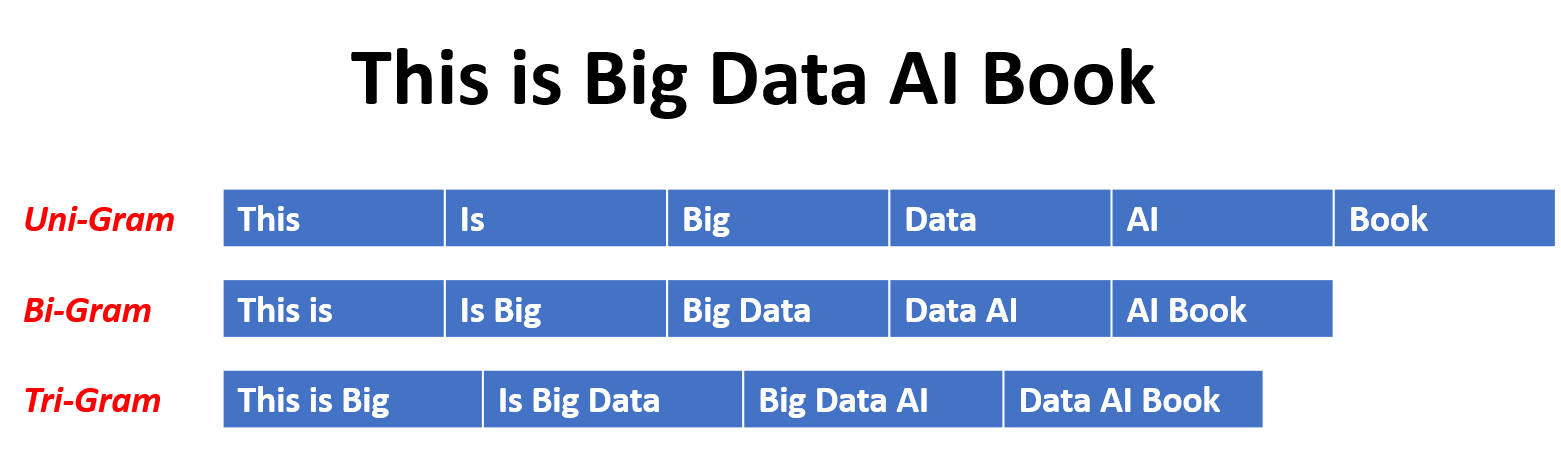

In [39]:
# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train['text'])
X_train_swears = X_train[['swear_present', 'swear_proportion', 'good_present', 'good_proportion']].values
X_train_final = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), pd.DataFrame(X_train_swears)], axis=1)

# Transform the test data
X_test_tfidf = vectorizer.transform(X_test['text'])
X_test_swears = X_test[['swear_present', 'swear_proportion', 'good_present', 'good_proportion']].values
X_test_final = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), pd.DataFrame(X_test_swears)], axis=1)

# Set seed for reproducibility
np.random.seed(42)

# **Naive Bayes Classifier**

In [40]:
# Initialize the Naive Bayes classifier
nb = MultinomialNB()

# Train the model
nb.fit(X_train_final, y_train)

# Test the model
y_pred_nb = nb.predict(X_test_final)

## Model evaluation of Naive Bayes

In [41]:
accuracy_nb= accuracy_score(y_test, y_pred_nb)
print(f" Model Accuracy for Naive Bayes Classifier: {accuracy_nb:2f}")

 Model Accuracy for Naive Bayes Classifier: 0.840278


In [42]:
# Print the classification report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        87
           1       0.84      0.74      0.79        57

    accuracy                           0.84       144
   macro avg       0.84      0.82      0.83       144
weighted avg       0.84      0.84      0.84       144



In [43]:
# Calculate and print ROC AUC score
roc_auc = metrics.roc_auc_score(y_test, y_pred_nb)
print(f'ROC AUC score: {roc_auc:.2f}')

ROC AUC score: 0.82


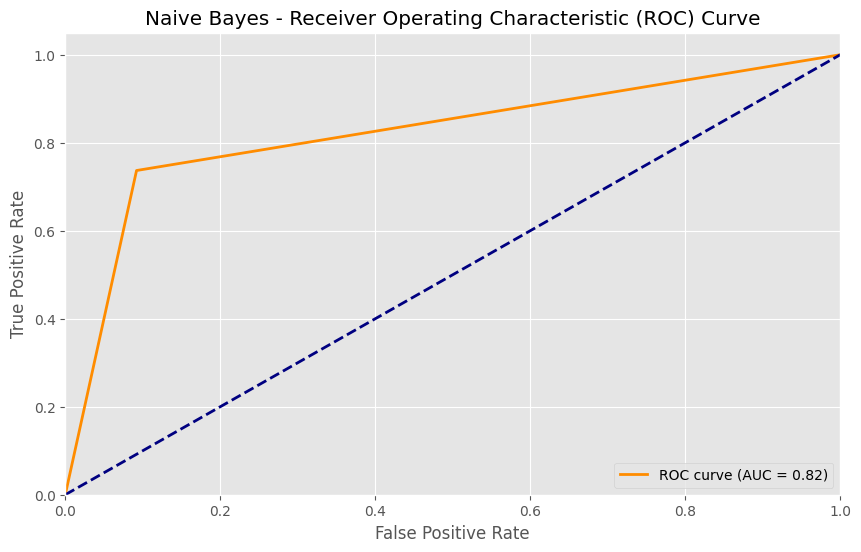

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_nb)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [45]:
# MSE and RMSE for Naive Bayes
mse_nb = mean_squared_error(y_test, y_pred_nb)
rmse_nb = np.sqrt(mse_nb)
print(f"\nMean Squared Error (MSE) for Naive Bayes: {mse_nb:.2f}")
print(f"Root Mean Squared Error (RMSE) for Naive Bayes: {rmse_nb:.2f}")


Mean Squared Error (MSE) for Naive Bayes: 0.16
Root Mean Squared Error (RMSE) for Naive Bayes: 0.40


# LSTM (Long Short-Term Memory) - Deep Learning RNN

In [46]:
# Set the timesteps and input_dim variables
timesteps = 4
input_dim = X_train_final.shape[1]

# Create a new variable to store the reshaped data
X_train_final_reshaped = X_train_final.to_numpy().astype('float32').reshape((-1, timesteps, input_dim))
X_test_final_reshaped = X_test_final.to_numpy().astype('float32').reshape((-1, timesteps, input_dim))
y_train_reshaped = y_train.to_numpy().reshape((-1, timesteps, 1))
y_test_reshaped = y_test.to_numpy().reshape((-1, timesteps, 1))

# Create an input layer for the LSTM network
input_layer = Input(shape=(timesteps, input_dim), name='input_layer')

# Add the LSTM layer with 64 units, dropout, and recurrent_dropout
lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(input_layer)

# Add a dense layer to the LSTM output
dense = Dense(32, activation='relu')(lstm)

# Add a dense output layer with a sigmoid activation function
output = Dense(1, activation='sigmoid')(dense)

# Create the model
model = Model(inputs=input_layer, outputs=output)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(tf.convert_to_tensor(X_train_final_reshaped), y_train_reshaped, epochs=10, batch_size=64)

# Test the model
y_pred_lstm = model.predict(X_test_final_reshaped)



Epoch 1/10


6/6 [==============================] - 5s 170ms/step - loss: 0.6920 - accuracy: 0.5525
Epoch 2/10
6/6 [==============================] - 1s 139ms/step - loss: 0.6810 - accuracy: 0.7022
Epoch 3/10
6/6 [==============================] - 1s 140ms/step - loss: 0.6644 - accuracy: 0.7801
Epoch 4/10
6/6 [==============================] - 1s 139ms/step - loss: 0.6407 - accuracy: 0.8002
Epoch 5/10
6/6 [==============================] - 1s 141ms/step - loss: 0.6104 - accuracy: 0.8156
Epoch 6/10
6/6 [==============================] - 1s 140ms/step - loss: 0.5722 - accuracy: 0.8256
Epoch 7/10
6/6 [==============================] - 1s 137ms/step - loss: 0.5235 - accuracy: 0.8565
Epoch 8/10
6/6 [==============================] - 1s 139ms/step - loss: 0.4659 - accuracy: 0.8858
Epoch 9/10
6/6 [==============================] - 1s 137ms/step - loss: 0.4058 - accuracy: 0.8935
Epoch 10/10
2/2 [==============================] - 0s 25ms/step


# Model Evaluation of LSTM

In [47]:
# Flatten the predicted and actual values to make them compatible with evaluation functions
y_pred_flat = y_pred_lstm.flatten()
y_test_flat = y_test_reshaped.flatten()

# Convert predicted probabilities to binary predictions using a threshold (0.5 in this case)
y_pred_binary = (y_pred_flat > 0.5).astype(int)

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test_flat, y_pred_binary)
print(f'Model Accuracy for LSTM: {accuracy_lstm:.4f}')

Model Accuracy for LSTM: 0.7986


In [48]:
# Print the classification report
report_lstm = classification_report(y_test_flat, y_pred_binary, output_dict=True)
print('Classification Report:\n', report_lstm)

Classification Report:
 {'0': {'precision': 0.7843137254901961, 'recall': 0.9195402298850575, 'f1-score': 0.8465608465608465, 'support': 87}, '1': {'precision': 0.8333333333333334, 'recall': 0.6140350877192983, 'f1-score': 0.7070707070707071, 'support': 57}, 'accuracy': 0.7986111111111112, 'macro avg': {'precision': 0.8088235294117647, 'recall': 0.7667876588021778, 'f1-score': 0.7768157768157768, 'support': 144}, 'weighted avg': {'precision': 0.8037173202614379, 'recall': 0.7986111111111112, 'f1-score': 0.7913459996793331, 'support': 144}}


In [49]:
# Calculate and print ROC AUC score
roc_auc_lstm = metrics.roc_auc_score(y_test_flat, y_pred_flat)
print(f'ROC-AUC Score: {roc_auc_lstm:.4f}')

ROC-AUC Score: 0.8391


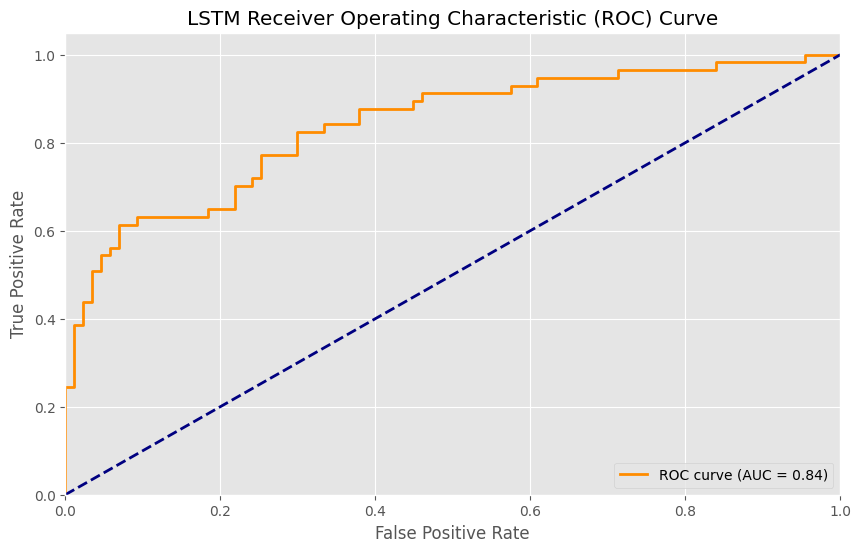

In [50]:
# Calculate the ROC curve
fpr_lstm, tpr_lstm, thresholds = roc_curve(y_test_flat, y_pred_flat)

# Calculate the area under the ROC curve
roc_auc = auc(fpr_lstm, tpr_lstm)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The curve is not smooth because we need to Flatten the y_test and y_pred since LSTM input requires a 3D array

In [51]:
# Calculate Mean Squared Error (MSE)
mse_lstm = mean_squared_error(y_test_flat, y_pred_flat)

# Calculate Root Mean Squared Error (RMSE)
rmse_lstm = np.sqrt(mse_lstm)

# Print the results
print(f"\nMean Squared Error (MSE) for LSTM: {mse_lstm:.4f}")
print(f"Root Mean Squared Error (RMSE) for LSTM: {rmse_lstm:.4f}")


Mean Squared Error (MSE) for LSTM: 0.1691
Root Mean Squared Error (RMSE) for LSTM: 0.4112


# Random Forest Classifier

In [52]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train_final, y_train)

# Test the model
y_pred_rf = rf_classifier.predict(X_test_final)

# Model Evaluation of Random Forest

In [53]:
accuracy_rf= accuracy_score(y_test, y_pred_rf)
print(f" Model Accuracy for Random Forest Classifier: {accuracy_rf:4f}")

 Model Accuracy for Random Forest Classifier: 0.798611


In [54]:
# Print the classification report
print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        87
           1       0.71      0.84      0.77        57

    accuracy                           0.80       144
   macro avg       0.79      0.81      0.80       144
weighted avg       0.81      0.80      0.80       144



In [55]:
# Calculate and print ROC AUC score
roc_auc = metrics.roc_auc_score(y_test, y_pred_rf)
print(f'ROC AUC score:', roc_auc)

ROC AUC score: 0.8061101028433152


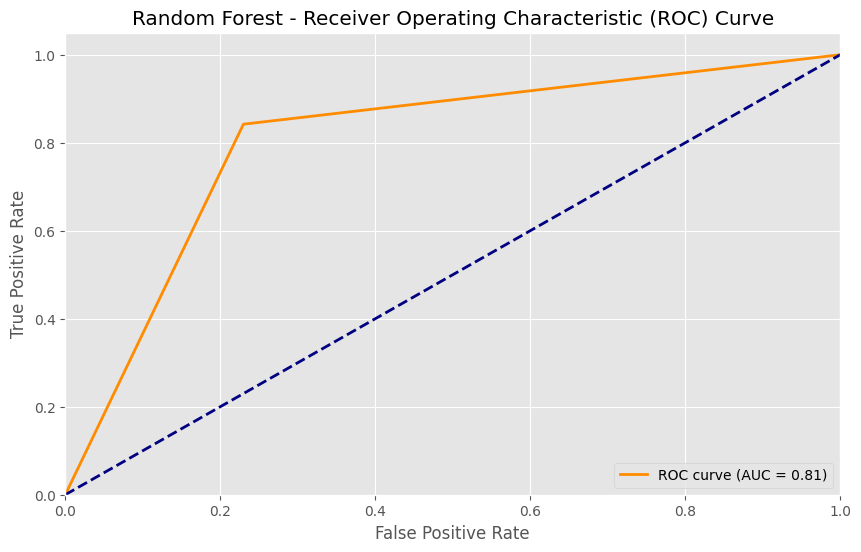

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [57]:
# Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f"\nMean Squared Error (MSE) for Random Forest: {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE) for Random Forest: {rmse_rf:.2f}")


Mean Squared Error (MSE) for Random Forest: 0.20
Root Mean Squared Error (RMSE) for Random Forest: 0.45


# Support Vector Machine

In [58]:
# Initialize the Support Vector Machine classifier
svm_classifier = SVC(random_state=42)

# Train the SVM model
svm_classifier.fit(X_train_final, y_train)

# Test the SVM model
y_pred_svm = svm_classifier.predict(X_test_final)

# Model Evaluation of SVM Classifier

In [59]:
accuracy_svm= accuracy_score(y_test, y_pred_svm)
print(f" Model Accuracy for SVM Classifier: {accuracy_svm:}")

 Model Accuracy for SVM Classifier: 0.7569444444444444


In [60]:
# Print the classification report for SVM
print("Support Vector Machine Classifier:")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine Classifier:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77        87
           1       0.64      0.86      0.74        57

    accuracy                           0.76       144
   macro avg       0.76      0.77      0.76       144
weighted avg       0.79      0.76      0.76       144



In [61]:
# Calculate and print ROC AUC score for SVM
roc_auc_svm = metrics.roc_auc_score(y_test, y_pred_svm)
print('ROC AUC score (Support Vector Machine):', roc_auc_svm)

ROC AUC score (Support Vector Machine): 0.7746521476104054


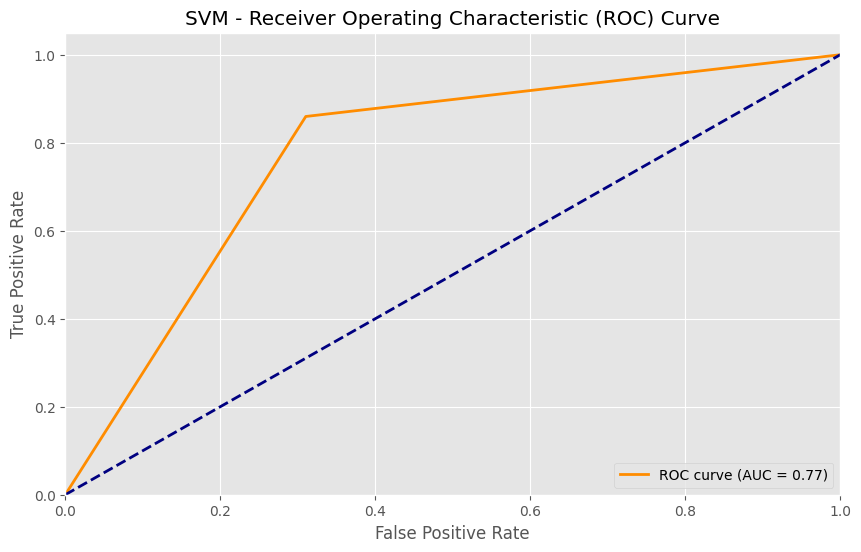

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [63]:
# SVM
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
print(f"\nMean Squared Error (MSE) for Support Vector Machine (SVM): {mse_svm:.2f}")
print(f"Root Mean Squared Error (RMSE) for Support Vector Machine (SVM): {rmse_svm:.2f}")


Mean Squared Error (MSE) for Support Vector Machine (SVM): 0.24
Root Mean Squared Error (RMSE) for Support Vector Machine (SVM): 0.49


# Logistic Regression

In [64]:
# Initialize the Logistic Regression classifier
logreg_classifier = LogisticRegression(random_state=42)

# Train the Logistic Regression model
logreg_classifier.fit(X_train_final, y_train)

# Test the Logistic Regression model
y_pred_logreg = logreg_classifier.predict(X_test_final)

# Model Evaluation of Logistic Regression

In [65]:
accuracy_logreg= accuracy_score(y_test, y_pred_logreg)
print(f" Model Accuracy for Logistic Regression Classifier: {accuracy_logreg:}")

 Model Accuracy for Logistic Regression Classifier: 0.8263888888888888


In [66]:
# Print the classification report for Logistic Regression
print("Logistic Regression Classifier:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Classifier:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        87
           1       0.78      0.79      0.78        57

    accuracy                           0.83       144
   macro avg       0.82      0.82      0.82       144
weighted avg       0.83      0.83      0.83       144



In [67]:
# Calculate and print ROC AUC score for Logistic Regression
roc_auc_logreg = metrics.roc_auc_score(y_test, y_pred_logreg)
print('ROC AUC score (Logistic Regression):', roc_auc_logreg)

ROC AUC score (Logistic Regression): 0.8200241984271023


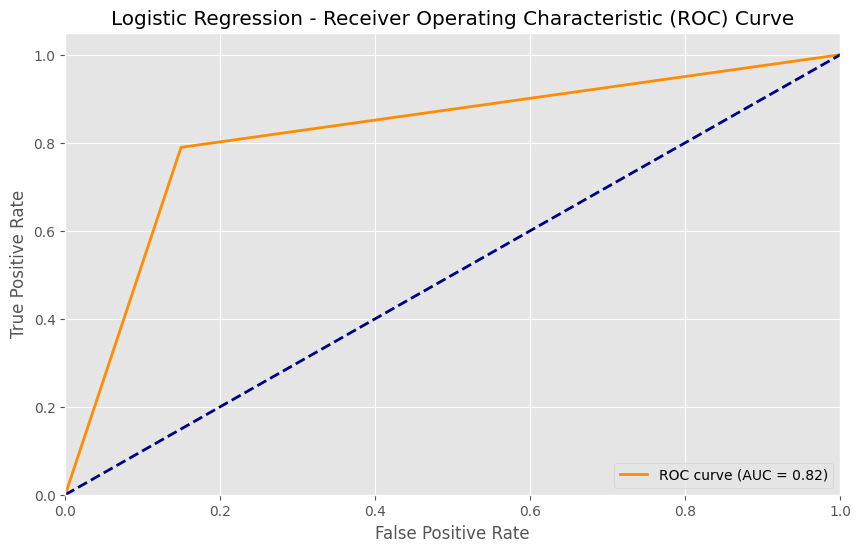

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg)

# Calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [69]:
# Logistic Regression
mse_logreg = mean_squared_error(y_test, y_pred_logreg)
rmse_logreg = np.sqrt(mse_logreg)
print(f"\nMean Squared Error (MSE) for Logistic Regression: {mse_logreg:.2f}")
print(f"Root Mean Squared Error (RMSE) for Logistic Regression: {rmse_logreg:.2f}")


Mean Squared Error (MSE) for Logistic Regression: 0.17
Root Mean Squared Error (RMSE) for Logistic Regression: 0.42


In [70]:
X_train_final.shape[1]

27781

# Comparison the performance of all the models by using accuracy,classification report, AUC and ROC curve, MSE and RMSE.

**Accuracy Score**

In [71]:
results = pd.DataFrame({
    'Model':['Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'LSTM'],
    'Accuracy Score':[accuracy_svm, accuracy_logreg, accuracy_rf, accuracy_nb, accuracy_lstm]})
result_df = results.sort_values(by = 'Accuracy Score', ascending = False)
result_df = result_df.set_index('Accuracy Score')
result_df

,Model
Accuracy Score,
0.840278,Naive Bayes
0.826389,Logistic Regression
0.798611,Random Forest
0.798611,LSTM
0.756944,Support Vector Machine


**Classification Report**

In [72]:
# Create a DataFrame for Classification Report
classification_reports = []

# Support Vector Machine
report_svm = classification_report(y_test, y_pred_svm, output_dict=True)
classification_reports.append({'Model': 'SVM', **report_svm['weighted avg']})

# Logistic Regression
report_logreg = classification_report(y_test, y_pred_logreg, output_dict=True)
classification_reports.append({'Model': 'Logistic Regression', **report_logreg['weighted avg']})

# Random Forest
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
classification_reports.append({'Model': 'Random Forest', **report_rf['weighted avg']})

# Naive Bayes
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
classification_reports.append({'Model': 'Naive Bayes', **report_nb['weighted avg']})

# LSTM
classification_reports.append({'Model': 'LSTM', **report_lstm['weighted avg']})

# Create DataFrame
classification_df = pd.DataFrame(classification_reports)
classification_df = classification_df.set_index('Model')

# Sort DataFrame by Score in descending order
classification_df = classification_df.sort_values(by='f1-score', ascending=False)

# Print the DataFrame
print(classification_df)

                     precision    recall  f1-score  support
Model                                                      
Naive Bayes           0.840257  0.840278  0.838142      144
Logistic Regression   0.826976  0.826389  0.826642      144
Random Forest         0.812032  0.798611  0.800677      144
LSTM                  0.803717  0.798611  0.791346      144
SVM                   0.788297  0.756944  0.759409      144


**AUC and ROC curve**

                          AUC
Model                        
LSTM                 0.839080
Naive Bayes          0.822444
Logistic Regression  0.820024
Random Forest        0.806110
SVM                  0.774652


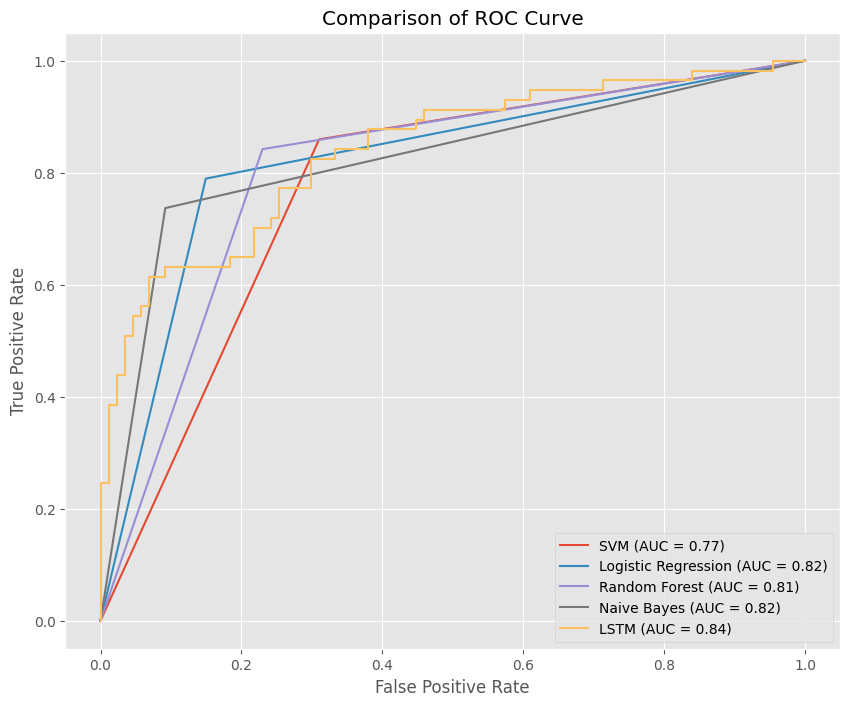

In [73]:
# Create a DataFrame for AUC
auc_results = []

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
auc_results.append({'Model': 'SVM', 'AUC': roc_auc_svm})

# Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_results.append({'Model': 'Logistic Regression', 'AUC': roc_auc_logreg})

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
auc_results.append({'Model': 'Random Forest', 'AUC': roc_auc_rf})

# Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
auc_results.append({'Model': 'Naive Bayes', 'AUC': roc_auc_nb})

# LSTM
auc_results.append({'Model': 'LSTM', 'AUC': roc_auc_lstm})

# Create DataFrame
auc_df = pd.DataFrame(auc_results)
auc_df = auc_df.set_index('Model')

# Sort DataFrame by AUC in descending order
auc_df = auc_df.sort_values(by='AUC', ascending=False)

# Print the DataFrame
print(auc_df)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curve')
plt.legend(loc='lower right')
plt.show()


**MSE and RMSE**

In [74]:
# Create a DataFrame for MSE and RMSE
mse_rmse_results = []

# SVM
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = sqrt(mse_svm)
mse_rmse_results.append({'Model': 'SVM', 'MSE': mse_svm, 'RMSE': rmse_svm})

# Logistic Regression
mse_logreg = mean_squared_error(y_test, y_pred_logreg)
rmse_logreg = np.sqrt(mse_logreg)
mse_rmse_results.append({'Model': 'Logistic Regression', 'MSE': mse_logreg, 'RMSE': rmse_logreg})

# Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mse_rmse_results.append({'Model': 'Random Forest', 'MSE': mse_rf, 'RMSE': rmse_rf})

# Naive Bayes
mse_nb = mean_squared_error(y_test, y_pred_nb)
rmse_nb = np.sqrt(mse_nb)
mse_rmse_results.append({'Model': 'Naive Bayes', 'MSE': mse_nb, 'RMSE': rmse_nb})

# LSTM
mse_rmse_results.append({'Model': 'LSTM', 'MSE': mse_lstm, 'RMSE': rmse_lstm})

# Create DataFrame
mse_rmse_df = pd.DataFrame(mse_rmse_results)
mse_rmse_df = mse_rmse_df.set_index('Model')

# Sort DataFrame by MSE in ascending order
mse_rmse_df = mse_rmse_df.sort_values(by='MSE', ascending=True)

# Print the DataFrame
print(mse_rmse_df)

                          MSE      RMSE
Model                                  
Naive Bayes          0.159722  0.399653
LSTM                 0.169079  0.411192
Logistic Regression  0.173611  0.416667
Random Forest        0.201389  0.448764
SVM                  0.243056  0.493007


In [75]:
# Check to see where the model failed to predict positive/negative tweets from highest accuracy model
results_df = X_test.copy()
results_df['true_labels'] = y_test
results_df['predicted_labels'] = y_pred_nb

# Print false positives
false_positives = results_df[(results_df['predicted_labels'] == 1) & (results_df['true_labels'] == 0)]
print("False Positives:")
print(false_positives['text'])

# Print false negatives
false_negatives = results_df[(results_df['predicted_labels'] == 0) & (results_df['true_labels'] == 1)]
print("\nFalse Negatives:")
print(false_negatives['text'])

False Positives:
119    laaaa cepat nye naik nak tengok geng bergabung...
521    vibes drama jaman jaman 1900 an terang an dram...
696                        kuat kudrat darurat nak hajat
988    sembako pasar tradisional tidak kenakan ppn te...
589    rakyat disuruh menjaga diri membisu tidak inis...
918    buseet jaman udah teknologi 50 jualan nya buki...
761    team alzakry paria no 1 keling penjilat lubang...
325            bang bawa membaca sikit stfc menasihati u
Name: text, dtype: object

False Negatives:
1480    keamanan keselamatan semua bersabar muncul var...
1096    orang cakap cam sedih gila cam for me dah teng...
1313    kahkahkasut2 rare ni mmg menggugatcuma laju x ...
1187               tapak tngn gatal nk hulur duit cmne ni
1076    salleh can meh susah dibuang pencen diaorang a...
253           peruntuk rm300 pesakit covid19 kategori b40
1260    dh rentas support sektor pelancongan sendiri t...
1314    betullah orang kata manusia ni je beria dah ju...
1341    rumah panas

# GUI from a real Twitter user to check the predicted sentiment 
<blockquote class="twitter-tweet"><p lang="in" dir="ltr">Kerajaan gagal. Kerajaan Muhyiddin gagal. Gagal, gagal total. Melingkuplah korang semua.</p>&mdash; lAN ZAINAL (@lANZAlNAL) <a href="https://twitter.com/lANZAlNAL/status/1389511823767056386?ref_src=twsrc%5Etfw">May 4, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

In [94]:
from tkinter import *

# Define the function to detect sentiment
def detect_sentiment():
    # Get the input text from the text area
    input_text = textArea.get("1.0", "end-1c")

    # Preprocess the input text
    preprocessed_text = preprocessing(input_text)

    # Transform the preprocessed text using the same vectorizer
    input_text_tfidf = vectorizer.transform([preprocessed_text])
    input_text_features = [[any(word in preprocessed_text for word in BAD_WORDS),
                            sum(preprocessed_text.count(word) for word in BAD_WORDS) / len(preprocessed_text.split()) if len(preprocessed_text.split()) > 0 else 0,
                            any(word in preprocessed_text for word in GOOD_WORDS),
                            sum(preprocessed_text.count(word) for word in GOOD_WORDS) / len(preprocessed_text.split()) if len(preprocessed_text.split()) > 0 else 0]]

    input_text_final = pd.concat([pd.DataFrame(input_text_tfidf.toarray()), pd.DataFrame(input_text_features)], axis=1)

    # Predict the sentiment of the input text
    prediction = nb.predict(input_text_final)[0]

    # Map the prediction to the corresponding sentiment label
    sentiment = {0: 'Negative', 1: 'Positive'}
    predicted_sentiment = sentiment[prediction]

    # Update the GUI with the predicted sentiment
    overallField.delete(0, END)
    overallField.insert(10, predicted_sentiment)

# Define the function to clear all fields
def clearAll():
    overallField.delete(0, END)
    textArea.delete(1.0, END)

# Define the function to exit the GUI
def exit():
    gui.destroy()

# Create the GUI
gui = Tk()
gui.config(background="light blue")
gui.title("Sentiment Detector")
gui.geometry("450x400")

# Create the widgets
enterText = Label(gui, text="Enter Your Sentence", bg="light yellow")
textArea = Text(gui, height=10, width=45, font="lucida 13")
check = Button(gui, text="Check Sentiment", fg="black", bg="light blue", command=detect_sentiment)
overall = Label(gui, text="Model Prediction :", bg="light yellow")
overallField = Entry(gui)
clear = Button(gui, text="Clear", fg="black", bg="light blue", command=clearAll)
Exit = Button(gui, text="Exit", fg="black", bg="light blue", command=exit)

# Add the widgets to the GUI
enterText.grid(row=0, column=2)
textArea.grid(row=1, column=2, padx=10, sticky=W)
check.grid(row=2, column=2)
overall.grid(row=3, column=2)
overallField.grid(row=4, column=2)
clear.grid(row=5, column=2)
Exit.grid(row=6, column=2)

# Start the GUI event loop
gui.mainloop()

